In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## U-NET

In [2]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

if __name__ == "__main__":
    x = torch.randn((2, 3, 512, 512))
    f = build_unet()
    y = f(x)
    print(y.shape)


torch.Size([2, 1, 512, 512])


## TEST

In [3]:
import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
from glob import glob # Added glob import
from torch.utils.data import DataLoader # Added DataLoader import
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from tqdm import tqdm
import imageio

## Testing

<ipython-input-47-c91150023ea5>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


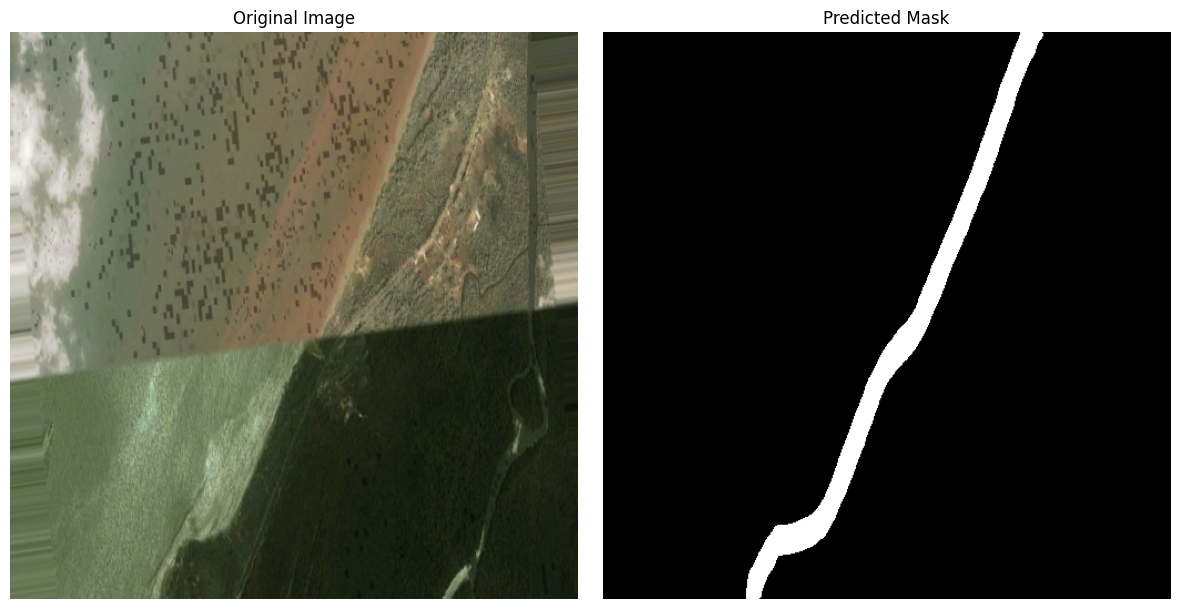

Predicted mask saved to /content/drive/MyDrive/boundary_drive_file/0_predicted_mask.png


In [ ]:
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

def preprocess_image(image_path, img_size=(512, 512)):
    """
    Preprocesses the input image for the model.

    Args:
        image_path (str): Path to the image file.
        img_size (tuple): Desired size for resizing the image (H, W).

    Returns:
        torch.Tensor: Preprocessed image tensor.
        np.ndarray: Original image for visualization.
    """
    # Read and resize the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for visualization
    image = cv2.resize(image, img_size)

    # Normalize and convert to tensor
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to [C, H, W] and normalize to [0, 1]
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    return image_tensor, original_image

def visualize_results(original_image, predicted_mask):
    """
    Visualizes the original image and predicted mask side by side.

    Args:
        original_image (np.ndarray): Original input image.
        predicted_mask (np.ndarray): Predicted binary mask.
    """
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask.squeeze(), cmap="gray")  # Squeeze the extra channel
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    Paths for drive
    model_path = "/content/drive/MyDrive/boundary_drive_file/final_model.pth"  # Update with your model path
    image_path = "/content/drive/MyDrive/boundary_drive_file/split_data/train/images/p7_aug_71.png"  # Update with the input image path
    output_mask_path = "/content/drive/MyDrive/boundary_drive_file/0_predicted_mask.png"  # Path to save the predicted mask

    # # Paths
    # model_path = "final_model.pth"  # Update with your model path
    # image_path = "split_data/train/images/p7_aug_71.png"  # Update with the input image path
    # output_mask_path = "Trials/predicted_mask.png"  # Path to save the predicted mask

    # Model parameters
    img_size = (512, 512)  # Image size for the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load trained model
    model = build_unet()  # Replace with your model's architecture definition
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Preprocess the input image
    image_tensor, original_image = preprocess_image(image_path, img_size)
    image_tensor = image_tensor.to(device)

    # Perform inference
    with torch.no_grad():
        pred_mask = model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask).squeeze(0).cpu().numpy()  # Squeeze batch dimension

    # Threshold the mask to binary
    binary_mask = (pred_mask > 0.5).astype(np.uint8) * 255  # Convert to binary and scale to 0–255

    # Squeeze the unnecessary dimension from binary_mask
    binary_mask = binary_mask.squeeze() # Removes the dimension with size 1

    # Visualize results
    visualize_results(original_image, binary_mask)

    # Save the predicted binary mask as a single-channel image
    cv2.imwrite(output_mask_path, binary_mask)  # Save the predicted mask as an image

    print(f"Predicted mask saved to {output_mask_path}")


<ipython-input-61-b85b2cdcd039>:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


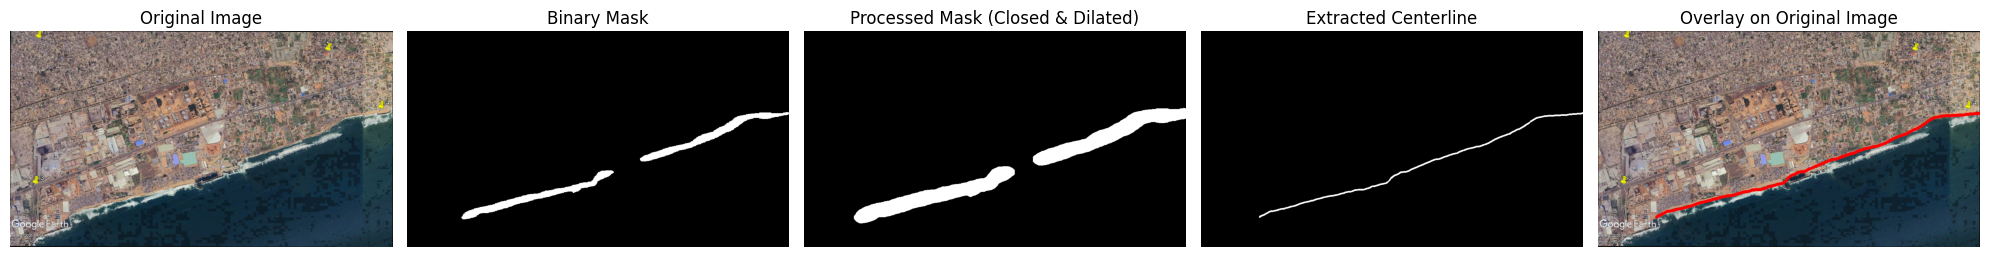

In [61]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.interpolate import interp1d

# Function to preprocess the image
def preprocess_image(image_path, img_size=(512, 512)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)

    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    return image_tensor, original_image

# Function to process and connect shoreline in binary mask
def process_shoreline(binary_mask, kernel_size=7, dilation_iterations=5):
    """
    Applies morphological operations to connect gaps in the shoreline and ensures continuity.
    """
    if len(binary_mask.shape) > 2:
        binary_mask = binary_mask[:, :, 0]

    binary_mask = (binary_mask > 0).astype(np.uint8) * 255  # Ensure binary format

    # Morphological closing to fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Dilation followed by erosion (Closing gaps and smoothing edges)
    dilated_mask = cv2.dilate(closed_mask, kernel, iterations=dilation_iterations)
    smoothed_mask = cv2.erode(dilated_mask, kernel, iterations=1)

    return smoothed_mask

# Function to extract centerline from the processed binary mask
def extract_centerline(binary_mask):
    """
    Extracts the centerline from the binary mask using thinning.
    """
    binary_mask = (binary_mask > 0).astype(np.uint8) * 255  # Ensure binary format
    skeleton = cv2.ximgproc.thinning(binary_mask)  # Thinning instead of skeletonize
    return skeleton

# Function to interpolate and further smooth disconnected segments
def interpolate_centerline(centerline, thickness=3):
    """
    Interpolates disconnected points in the centerline and ensures visibility by drawing thicker lines.
    """
    coords = np.column_stack(np.where(centerline > 0))
    if len(coords) < 2:
        return centerline  # Not enough points to interpolate

    x, y = coords[:, 1], coords[:, 0]

    # Sort x-values to ensure correct interpolation order
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Linear interpolation
    interp_func = interp1d(x_sorted, y_sorted, kind="linear", fill_value="extrapolate")
    new_x = np.linspace(min(x_sorted), max(x_sorted), num=200)
    new_y = interp_func(new_x).astype(int)

    # Create a blank image for the interpolated centerline
    interpolated_centerline = np.zeros_like(centerline)

    # Draw a continuous thick line instead of isolated points
    for i in range(len(new_x) - 1):
        cv2.line(interpolated_centerline,
                 (int(new_x[i]), new_y[i]),
                 (int(new_x[i + 1]), new_y[i + 1]),
                 255, thickness)

    return interpolated_centerline


# Function to overlay centerline on the original image
def overlay_centerline(original_image, centerline, line_color=(255, 0, 0), thickness=3):
    if centerline.ndim > 2:
        centerline = np.squeeze(centerline)

    overlay_image = original_image.copy()
    coords = np.column_stack(np.where(centerline > 0))

    # Draw the centerline as a polyline instead of dots
    if len(coords) > 1:
        for i in range(len(coords) - 1):
            cv2.line(overlay_image, (coords[i][1], coords[i][0]), (coords[i + 1][1], coords[i + 1][0]),
                     color=line_color, thickness=thickness)

    return overlay_image


# Function to visualize results
def visualize_results(original_image, binary_mask, processed_mask, centerline, overlay_image):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Binary Mask")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(processed_mask, cmap="gray")
    plt.title("Processed Mask (Closed & Dilated)")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(centerline, cmap="gray")
    plt.title("Extracted Centerline")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(overlay_image)
    plt.title("Overlay on Original Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Main workflow
if __name__ == "__main__":
    # Paths
    model_path = "/content/drive/MyDrive/boundary_drive_file/final_model.pth"
    image_path = "/content/drive/MyDrive/boundary_drive_file/trails/r2023.tif"

    # Model parameters
    img_size = (512, 512)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load trained model
    model = build_unet()  # Replace with your U-Net model definition
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Preprocess input image
    image_tensor, original_image = preprocess_image(image_path, img_size)
    image_tensor = image_tensor.to(device)

    # Perform inference
    with torch.no_grad():
        pred_mask = model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask).squeeze(0).cpu().numpy()

        if pred_mask.ndim == 3:
            pred_mask = pred_mask[0]

    # Threshold the mask to binary
    binary_mask = (pred_mask > 0.5).astype(np.uint8)

    # Resize the binary mask to match the original image dimensions
    binary_mask_resized = cv2.resize(binary_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Process shoreline to close gaps
    processed_mask = process_shoreline(binary_mask_resized, kernel_size=7, dilation_iterations=5)

    # Extract centerline using thinning
    centerline = extract_centerline(processed_mask)

    # Interpolate centerline to further smoothen gaps
    interpolated_centerline = interpolate_centerline(centerline)

    # Overlay the centerline on the original image
    overlay_image = overlay_centerline(original_image, interpolated_centerline)

    # Visualize results
    visualize_results(original_image, binary_mask_resized, processed_mask, interpolated_centerline, overlay_image)


## Overlay line on two images for changes


<ipython-input-66-ffb7459660c2>:152: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


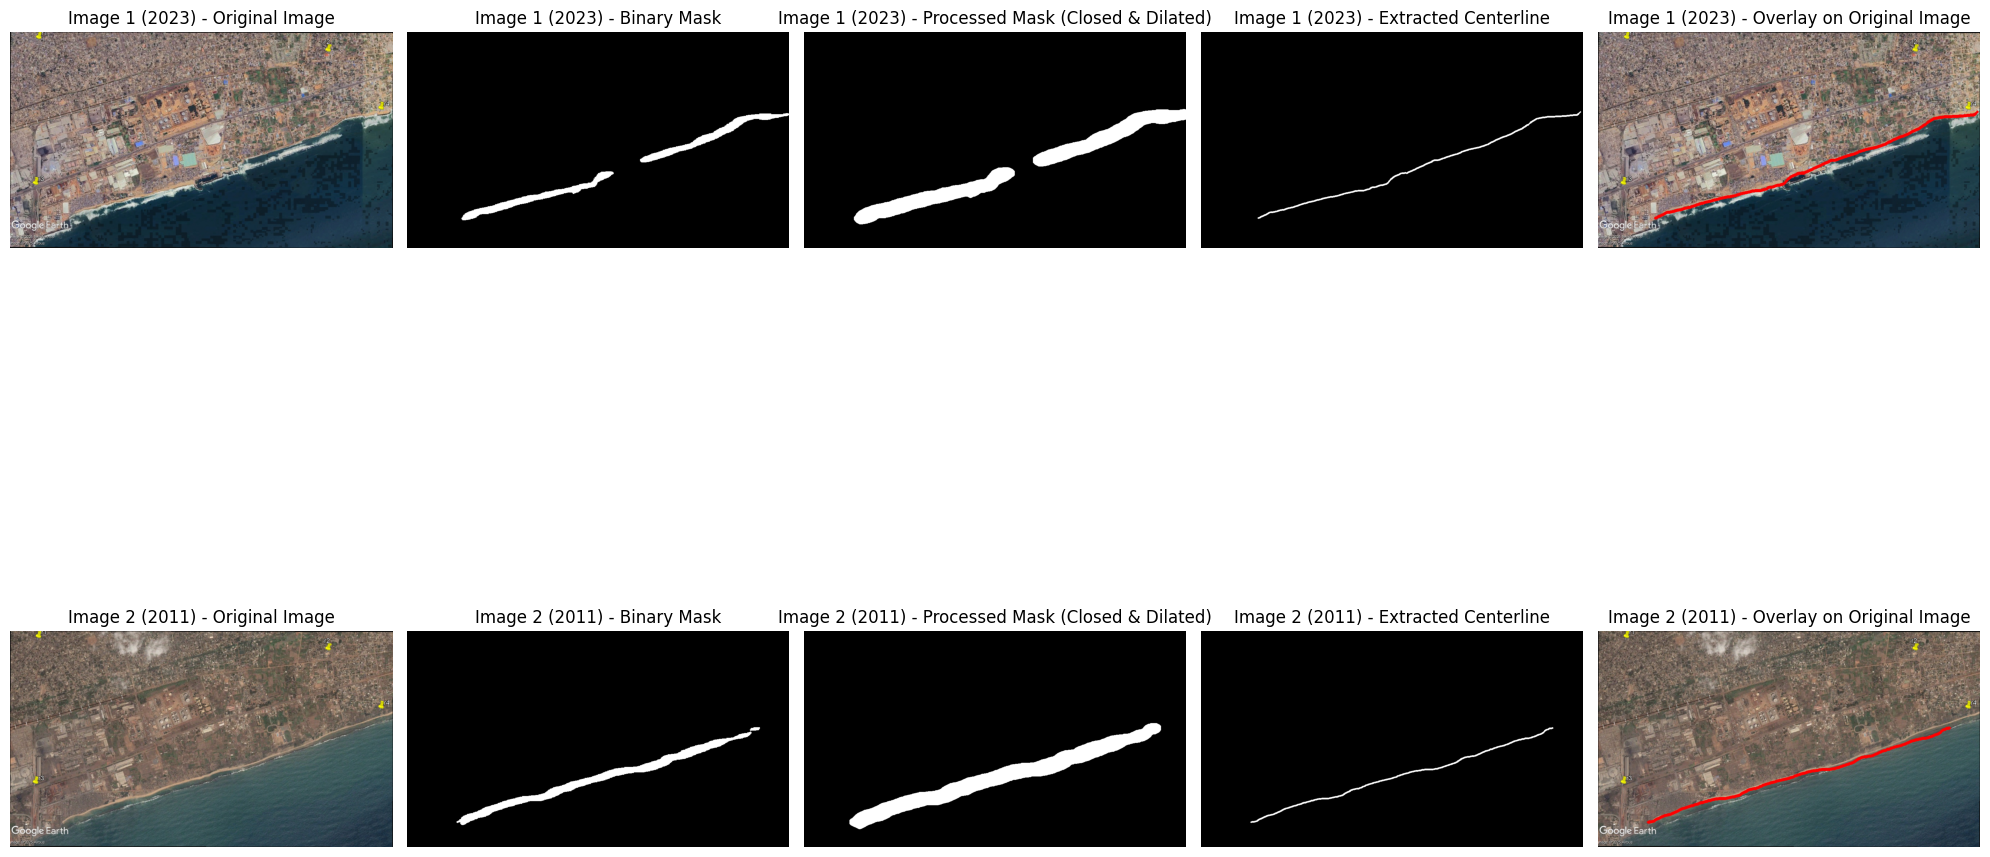

In [66]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from skimage.morphology import skeletonize
from scipy.interpolate import interp1d

# Function to preprocess images
def preprocess_image(image_path, img_size=(512, 512)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)

    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    return image_tensor, original_image

# Function to process shoreline by filling gaps
def process_shoreline(binary_mask, kernel_size=7, dilation_iterations=5):
    """
    Applies morphological operations to connect gaps in the shoreline and ensures continuity.
    """
    if len(binary_mask.shape) > 2:
        binary_mask = binary_mask[:, :, 0]

    binary_mask = (binary_mask > 0).astype(np.uint8) * 255  # Ensure binary format

    # Morphological closing to fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Dilation followed by erosion (Closing gaps and smoothing edges)
    dilated_mask = cv2.dilate(closed_mask, kernel, iterations=dilation_iterations)
    smoothed_mask = cv2.erode(dilated_mask, kernel, iterations=1)

    return smoothed_mask

# Function to extract centerline from processed shoreline
def extract_centerline(binary_mask):
    """
    Extracts the centerline from the binary mask using thinning.
    """
    binary_mask = (binary_mask > 0).astype(np.uint8) * 255  # Ensure binary format
    skeleton = skeletonize(binary_mask)
    return (skeleton * 255).astype(np.uint8)

# Function to interpolate centerline for smoothness
def interpolate_centerline(centerline, thickness=3):
    """
    Interpolates disconnected points in the centerline and ensures visibility by drawing thicker lines.
    """
    coords = np.column_stack(np.where(centerline > 0))
    if len(coords) < 2:
        return centerline  # Not enough points to interpolate

    x, y = coords[:, 1], coords[:, 0]

    # Sort x-values for correct interpolation order
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Linear interpolation
    interp_func = interp1d(x_sorted, y_sorted, kind="linear", fill_value="extrapolate")
    new_x = np.linspace(min(x_sorted), max(x_sorted), num=200)
    new_y = interp_func(new_x).astype(int)

    # Create blank image for interpolated centerline
    interpolated_centerline = np.zeros_like(centerline)

    # Draw a continuous thick line instead of isolated points
    for i in range(len(new_x) - 1):
        cv2.line(interpolated_centerline,
                 (int(new_x[i]), new_y[i]),
                 (int(new_x[i + 1]), new_y[i + 1]),
                 255, thickness) # Removed extra indent here

    return interpolated_centerline

# Function to overlay centerline on the original image
def overlay_centerline(original_image, centerline, line_color=(255, 0, 0), thickness=3):
    if centerline.ndim > 2:
        centerline = np.squeeze(centerline)

    overlay_image = original_image.copy()
    coords = np.column_stack(np.where(centerline > 0))

    # Draw the centerline as a polyline instead of dots
    if len(coords) > 1:
        for i in range(len(coords) - 1):
            cv2.line(overlay_image, (coords[i][1], coords[i][0]), (coords[i + 1][1], coords[i + 1][0]),
                     color=line_color, thickness=thickness)

    return overlay_image

# Function to visualize results for two images
def visualize_results(images_data, titles):
    num_images = len(images_data)
    plt.figure(figsize=(20, 8 * num_images))

    for i, (original_image, binary_mask, processed_mask, centerline, overlay_image) in enumerate(images_data):
        row_offset = i * 5  # Arrange images in separate rows

        plt.subplot(num_images, 5, row_offset + 1)
        plt.imshow(original_image)
        plt.title(f"{titles[i]} - Original Image")
        plt.axis("off")

        plt.subplot(num_images, 5, row_offset + 2)
        plt.imshow(binary_mask, cmap="gray")
        plt.title(f"{titles[i]} - Binary Mask")
        plt.axis("off")

        plt.subplot(num_images, 5, row_offset + 3)
        plt.imshow(processed_mask, cmap="gray")
        plt.title(f"{titles[i]} - Processed Mask (Closed & Dilated)")
        plt.axis("off")

        plt.subplot(num_images, 5, row_offset + 4)
        plt.imshow(centerline, cmap="gray")
        plt.title(f"{titles[i]} - Extracted Centerline")
        plt.axis("off")

        plt.subplot(num_images, 5, row_offset + 5)
        plt.imshow(overlay_image)
        plt.title(f"{titles[i]} - Overlay on Original Image")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Main workflow
if __name__ == "__main__":
    # Paths
    model_path = "/content/drive/MyDrive/boundary_drive_file/final_model.pth"
    image_paths = [
        "/content/drive/MyDrive/boundary_drive_file/trails/r2023.tif",
        "/content/drive/MyDrive/boundary_drive_file/trails/r2011.tif"
    ]

    # Load trained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = build_unet()  # Ensure build_unet() is defined before running
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    images_data = []
    titles = ["Image 1 (2023)", "Image 2 (2011)"]

    # Process both images
    for i, image_path in enumerate(image_paths):
        image_tensor, original_image = preprocess_image(image_path)
        image_tensor = image_tensor.to(device)

        with torch.no_grad():
            pred_mask = model(image_tensor)
            pred_mask = torch.sigmoid(pred_mask).squeeze(0).cpu().numpy()

        binary_mask = np.squeeze((pred_mask > 0.5).astype(np.uint8))

        # Resize binary_mask to match original image
        binary_mask_resized = cv2.resize(binary_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Process shoreline for continuity
        processed_mask = process_shoreline(binary_mask_resized, kernel_size=7, dilation_iterations=5)

        # Extract centerline
        centerline = extract_centerline(processed_mask)

        # Interpolate centerline to smooth out gaps
        interpolated_centerline = interpolate_centerline(centerline)

        # Overlay the centerline on the original image
        overlay_image = overlay_centerline(original_image, interpolated_centerline)

        # Store results
        images_data.append((original_image, binary_mask_resized, processed_mask, interpolated_centerline, overlay_image))

    # Visualize results
    visualize_results(images_data, titles)


## Plotting dual polyline



<ipython-input-4-d7770324ed40>:120: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device), strict=False)


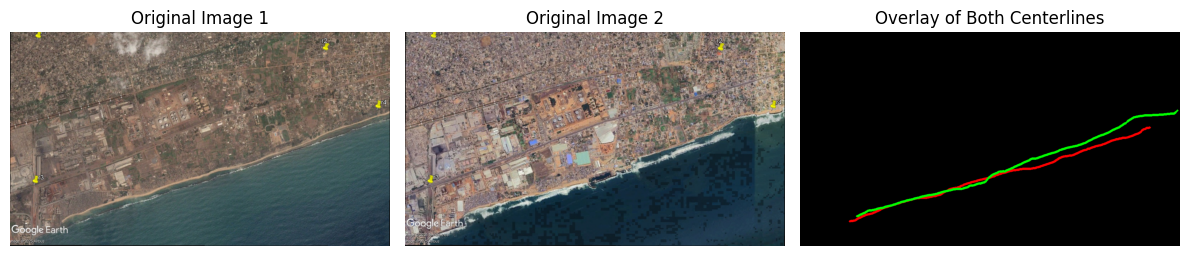

In [4]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.interpolate import interp1d
from skimage.morphology import skeletonize

# Function to preprocess the image
def preprocess_image(image_path, img_size=(512, 512)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)

    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    return image_tensor, original_image

# Function to process and connect shoreline in binary mask
def process_shoreline(binary_mask, kernel_size=7, dilation_iterations=5):
    """
    Applies morphological operations to connect gaps in the shoreline and ensures continuity.
    """
    if len(binary_mask.shape) > 2:
        binary_mask = binary_mask[:, :, 0]

    binary_mask = (binary_mask > 0).astype(np.uint8) * 255  # Ensure binary format

    # Morphological closing to fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Dilation followed by erosion (Closing gaps and smoothing edges)
    dilated_mask = cv2.dilate(closed_mask, kernel, iterations=dilation_iterations)
    smoothed_mask = cv2.erode(dilated_mask, kernel, iterations=1)

    return smoothed_mask

# Function to extract centerline from processed shoreline
def extract_centerline(binary_mask):
    """
    Extracts a continuous centerline using thinning and interpolation.
    """
    binary_mask = (binary_mask > 0).astype(np.uint8)  # Ensure binary format
    skeleton = skeletonize(binary_mask)  # Thinning instead of OpenCV thinning
    return (skeleton * 255).astype(np.uint8)

# Function to interpolate and smooth disconnected segments
def interpolate_centerline(centerline, thickness=3):
    """
    Interpolates disconnected points in the centerline and ensures visibility by drawing thicker lines.
    """
    coords = np.column_stack(np.where(centerline > 0))
    if len(coords) < 2:
        return centerline  # Not enough points to interpolate

    x, y = coords[:, 1], coords[:, 0]

    # Sort x-values to ensure correct interpolation order
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Linear interpolation
    interp_func = interp1d(x_sorted, y_sorted, kind="linear", fill_value="extrapolate")
    new_x = np.linspace(min(x_sorted), max(x_sorted), num=200)
    new_y = interp_func(new_x).astype(int)

    # Create a blank image for the interpolated centerline
    interpolated_centerline = np.zeros_like(centerline)

    # Draw a continuous thick line instead of isolated points
    for i in range(len(new_x) - 1):
        cv2.line(interpolated_centerline,
                 (int(new_x[i]), new_y[i]),
                 (int(new_x[i + 1]), new_y[i + 1]),
                 255, thickness)

    return interpolated_centerline

# Function to overlay two centerlines together on a single image
def overlay_both_centerlines(image_shape, centerline1, centerline2, color1=(255, 0, 0), color2=(0, 255, 0)):
    """
    Overlays two extracted centerlines with different colors.
    """
    overlay_image = np.zeros((image_shape[0], image_shape[1], 3), dtype=np.uint8)

    # Add first centerline (Red)
    coords1 = np.column_stack(np.where(centerline1 > 0))
    for y, x in coords1:
        cv2.circle(overlay_image, (x, y), radius=1, color=color1, thickness=-1)

    # Add second centerline (Green)
    coords2 = np.column_stack(np.where(centerline2 > 0))
    for y, x in coords2:
        cv2.circle(overlay_image, (x, y), radius=1, color=color2, thickness=-1)

    return overlay_image

# Main workflow
if __name__ == "__main__":
    # Paths
    model_path = "/content/drive/MyDrive/boundary_drive_file/final_model.pth"
    image_paths = [
        "/content/drive/MyDrive/boundary_drive_file/trails/r2011.tif",
        "/content/drive/MyDrive/boundary_drive_file/trails/r2023.tif"
    ]

    # Load trained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure build_unet() is defined before executing this
    model = build_unet()  # Ensure this function is defined before running
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model.to(device)
    model.eval()

    centerlines = []
    original_images = []

    # Process both images
    for image_path in image_paths:
        image_tensor, original_image = preprocess_image(image_path)
        image_tensor = image_tensor.to(device)

        with torch.no_grad():
            pred_mask = model(image_tensor)
            pred_mask = torch.sigmoid(pred_mask).squeeze(0).cpu().numpy()

        # Ensure binary_mask is single-channel
        binary_mask = np.squeeze((pred_mask > 0.5).astype(np.uint8))

        # Resize binary_mask properly
        binary_mask_resized = cv2.resize(binary_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Process shoreline to close gaps
        processed_mask = process_shoreline(binary_mask_resized, kernel_size=7, dilation_iterations=5)

        # Extract centerline using thinning
        centerline = extract_centerline(processed_mask)

        # Interpolate centerline to further smoothen gaps
        interpolated_centerline = interpolate_centerline(centerline)

        centerlines.append(interpolated_centerline)
        original_images.append(original_image)

    # Ensure both centerlines are available
    if len(centerlines) == 2:
        combined_centerline = overlay_both_centerlines(original_images[0].shape, centerlines[0], centerlines[1])

        # Visualize results
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(original_images[0])
        plt.title("Original Image 1")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(original_images[1])
        plt.title("Original Image 2")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(combined_centerline)
        plt.title("Overlay of Both Centerlines")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


# TO METER

<ipython-input-5-b85b2cdcd039>:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


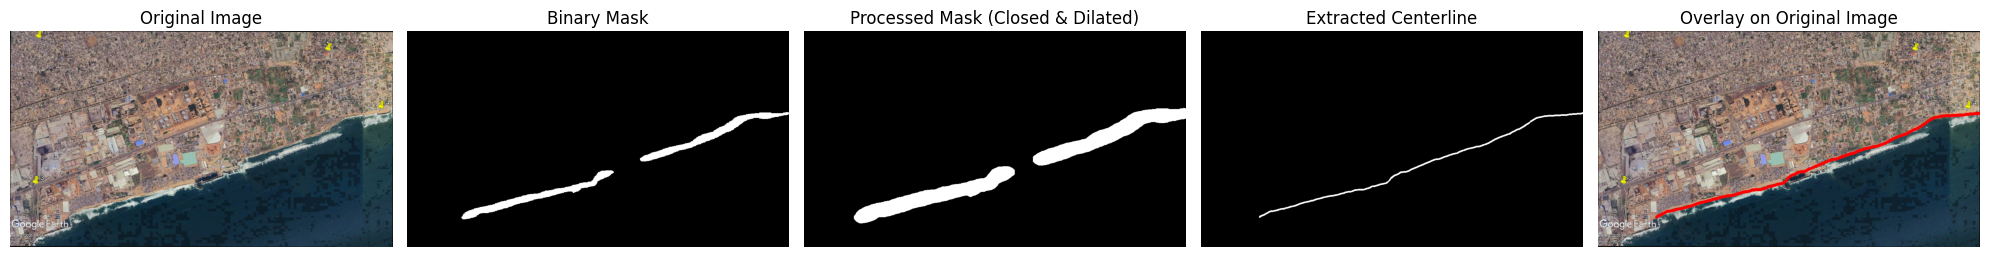

In [5]:
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from scipy.interpolate import interp1d

# Function to preprocess the image
def preprocess_image(image_path, img_size=(512, 512)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, img_size)

    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    return image_tensor, original_image

# Function to process and connect shoreline in binary mask
def process_shoreline(binary_mask, kernel_size=7, dilation_iterations=5):
    """
    Applies morphological operations to connect gaps in the shoreline and ensures continuity.
    """
    if len(binary_mask.shape) > 2:
        binary_mask = binary_mask[:, :, 0]

    binary_mask = (binary_mask > 0).astype(np.uint8) * 255  # Ensure binary format

    # Morphological closing to fill gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Dilation followed by erosion (Closing gaps and smoothing edges)
    dilated_mask = cv2.dilate(closed_mask, kernel, iterations=dilation_iterations)
    smoothed_mask = cv2.erode(dilated_mask, kernel, iterations=1)

    return smoothed_mask

# Function to extract centerline from the processed binary mask
def extract_centerline(binary_mask):
    """
    Extracts the centerline from the binary mask using thinning.
    """
    binary_mask = (binary_mask > 0).astype(np.uint8) * 255  # Ensure binary format
    skeleton = cv2.ximgproc.thinning(binary_mask)  # Thinning instead of skeletonize
    return skeleton

# Function to interpolate and further smooth disconnected segments
def interpolate_centerline(centerline, thickness=3):
    """
    Interpolates disconnected points in the centerline and ensures visibility by drawing thicker lines.
    """
    coords = np.column_stack(np.where(centerline > 0))
    if len(coords) < 2:
        return centerline  # Not enough points to interpolate

    x, y = coords[:, 1], coords[:, 0]

    # Sort x-values to ensure correct interpolation order
    sorted_indices = np.argsort(x)
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # Linear interpolation
    interp_func = interp1d(x_sorted, y_sorted, kind="linear", fill_value="extrapolate")
    new_x = np.linspace(min(x_sorted), max(x_sorted), num=200)
    new_y = interp_func(new_x).astype(int)

    # Create a blank image for the interpolated centerline
    interpolated_centerline = np.zeros_like(centerline)

    # Draw a continuous thick line instead of isolated points
    for i in range(len(new_x) - 1):
        cv2.line(interpolated_centerline,
                 (int(new_x[i]), new_y[i]),
                 (int(new_x[i + 1]), new_y[i + 1]),
                 255, thickness)

    return interpolated_centerline


# Function to overlay centerline on the original image
def overlay_centerline(original_image, centerline, line_color=(255, 0, 0), thickness=3):
    if centerline.ndim > 2:
        centerline = np.squeeze(centerline)

    overlay_image = original_image.copy()
    coords = np.column_stack(np.where(centerline > 0))

    # Draw the centerline as a polyline instead of dots
    if len(coords) > 1:
        for i in range(len(coords) - 1):
            cv2.line(overlay_image, (coords[i][1], coords[i][0]), (coords[i + 1][1], coords[i + 1][0]),
                     color=line_color, thickness=thickness)

    return overlay_image


# Function to visualize results
def visualize_results(original_image, binary_mask, processed_mask, centerline, overlay_image):
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(binary_mask, cmap="gray")
    plt.title("Binary Mask")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(processed_mask, cmap="gray")
    plt.title("Processed Mask (Closed & Dilated)")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(centerline, cmap="gray")
    plt.title("Extracted Centerline")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(overlay_image)
    plt.title("Overlay on Original Image")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Main workflow
if __name__ == "__main__":
    # Paths
    model_path = "/content/drive/MyDrive/boundary_drive_file/final_model.pth"
    image_path = "/content/drive/MyDrive/boundary_drive_file/trails/r2023.tif"

    # Model parameters
    img_size = (512, 512)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load trained model
    model = build_unet()  # Replace with your U-Net model definition
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Preprocess input image
    image_tensor, original_image = preprocess_image(image_path, img_size)
    image_tensor = image_tensor.to(device)

    # Perform inference
    with torch.no_grad():
        pred_mask = model(image_tensor)
        pred_mask = torch.sigmoid(pred_mask).squeeze(0).cpu().numpy()

        if pred_mask.ndim == 3:
            pred_mask = pred_mask[0]

    # Threshold the mask to binary
    binary_mask = (pred_mask > 0.5).astype(np.uint8)

    # Resize the binary mask to match the original image dimensions
    binary_mask_resized = cv2.resize(binary_mask, (original_image.shape[1], original_image.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Process shoreline to close gaps
    processed_mask = process_shoreline(binary_mask_resized, kernel_size=7, dilation_iterations=5)

    # Extract centerline using thinning
    centerline = extract_centerline(processed_mask)

    # Interpolate centerline to further smoothen gaps
    interpolated_centerline = interpolate_centerline(centerline)

    # Overlay the centerline on the original image
    overlay_image = overlay_centerline(original_image, interpolated_centerline)

    # Visualize results
    visualize_results(original_image, binary_mask_resized, processed_mask, interpolated_centerline, overlay_image)


In [8]:
# !pip install rasterio
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import LineString
import numpy as np
import json

def save_centerline_to_geojson(centerline, image_path, output_path="/content/drive/MyDrive/boundary_drive_file/trails/centerline.geojson"):
    """
    Saves the extracted centerline to a GeoJSON file with georeferencing.

    Args:
        centerline (numpy.ndarray): The binary image containing the centerline.
        image_path (str): Path to the georeferenced image.
        output_path (str): Path to save the GeoJSON.
    """
    with rasterio.open(image_path) as src:
        transform = src.transform  # Get georeferencing transform
        crs = src.crs  # Get projection info

    # Extract pixel coordinates of centerline
    coords = np.column_stack(np.where(centerline > 0))  # (row, col)

    if len(coords) < 2:
        raise ValueError("No valid centerline detected.")

    # Convert pixel coordinates to real-world coordinates
    real_coords = [transform * (int(x), int(y)) for y, x in coords]

    # Create a LineString geometry
    centerline_geom = LineString(real_coords)

    # Save as GeoJSON
    gdf = gpd.GeoDataFrame({"geometry": [centerline_geom]}, crs=crs)
    gdf.to_file(output_path, driver="GeoJSON")
    print(f"Centerline saved as {output_path}")

# Example usage
save_centerline_to_geojson(interpolated_centerline, "/content/drive/MyDrive/boundary_drive_file/trails/r2023.tif")


Centerline saved as /content/drive/MyDrive/boundary_drive_file/trails/centerline.geojson


## Read json file

## Reprojection

In [19]:
print(gdf.head())  # Print first few rows
print(gdf.crs)     # Confirm CRS
print(gdf.geometry)  # Check if geometry is valid


                                            geometry
0  LINESTRING (1.33318 6.16155, 1.33322 6.16155, ...
EPSG:4326
0    LINESTRING (1.33318 6.16155, 1.33322 6.16155, ...
Name: geometry, dtype: geometry


In [26]:
import geopandas as gpd
import leafmap

# Load GeoJSON
geojson_path = "/content/drive/MyDrive/boundary_drive_file/trails/centerline.geojson"
gdf = gpd.read_file(geojson_path)

# Ensure gdf is not empty
if gdf.empty:
    raise ValueError("Error: GeoDataFrame is empty. Check if the GeoJSON file contains valid data.")

# Print first few rows
# print(gdf.head())

# Reproject to EPSG:4326
gdf = gdf.to_crs(epsg=4326)
print("Reprojected CRS:", gdf.crs)

# Compute centroid for map centering (but don't add it to gdf)
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

# Create map
m = leafmap.Map(center=[center_lat, center_lon], zoom=15)

# Add centerline layer (Only use the geometry column)
m.add_gdf(gdf[["geometry"]], layer_name="Centerline")

# Show map
m

Reprojected CRS: EPSG:4326


Map(center=[6.1552603982173, 1.3139275536061596], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

## Plotting json file

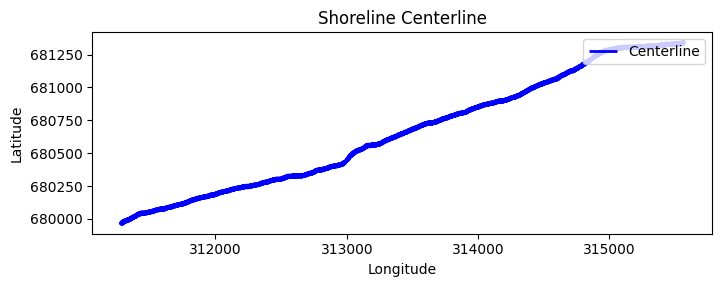

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

def visualize_centerline_matplotlib(file_path):
    """
    Visualizes the centerline GeoJSON file using Matplotlib.

    Args:
        file_path (str): Path to the GeoJSON file.
    """
    # Load GeoJSON as GeoDataFrame
    gdf = gpd.read_file(file_path)

    # Plot the centerline
    fig, ax = plt.subplots(figsize=(8, 6))
    gdf.plot(ax=ax, color="blue", linewidth=2, label="Centerline")

    # Customize the plot
    ax.set_title("Shoreline Centerline")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend()

    # Show the plot
    plt.show()

# Example usage
visualize_centerline_matplotlib(geojson_path)


In [12]:
import geopandas as gpd
import folium

def visualize_centerline_folium(file_path):
    """
    Visualizes the centerline GeoJSON file using Folium.

    Args:
        file_path (str): Path to the GeoJSON file.
    """
    # Load GeoJSON as GeoDataFrame
    gdf = gpd.read_file(file_path)

    # Get the centroid of the centerline to center the map
    center = gdf.geometry.centroid.iloc[0].coords[0][::-1]  # Convert (x, y) to (lat, lon)

    # Create Folium Map
    m = folium.Map(location=center, zoom_start=15)

    # Add the centerline to the map
    folium.GeoJson(gdf, name="Centerline").add_to(m)

    # Show map
    return m

# Example usage
geojson_path = "/content/drive/MyDrive/boundary_drive_file/trails/centerline.geojson"
visualize_centerline_folium(geojson_path)


In [16]:
# !pip install leafmap

In [15]:
import leafmap

def visualize_geojson(file_path):
    m = leafmap.Map(center=(6.5, 3.4), zoom=10)  # Adjust center and zoom as needed
    m.add_geojson(file_path, layer_name="Centerline")
    return m

# Example usage
geojson_path = "/content/drive/MyDrive/boundary_drive_file/trails/centerline.geojson"
m = visualize_geojson(geojson_path)
m  # Display the map


Map(center=[6.5, 3.4], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [17]:
import leafmap

# Create an interactive map
m = leafmap.Map()

# Display the map
m


Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…